# Add non-default packages

In [ ]:
!pip install anndata
!pip install scanpy
!pip install cupy-cuda12x
!pip install scimap

^C


In [ ]:
!sudo apt install python3-cffi
!pip install --upgrade cffi==1.17.1
# !pip uninstall cffi

In [ ]:
!pip install matplotlib

# Move files from buckets to colab instance

In [ ]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'isb-cgc-external-005'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
!gsutil cp gs://single_sample_features/MEL01-3-1.csv  /cell_data/MEL01-3-1.csv

In [ ]:
!gsutil cp gs://single_sample_features/cell_centered_embeddings/combined_embeddings.h5ad  /embedding_data/combined_embeddings.h5ad

In [ ]:
!gsutil cp gs://single_sample_features/phenotyping_rule_tables/phenotyping_tables_v2_w_whitespace_tumor_corrected.csv  /phenotyping_rule_tables/phenotyping_tables_v2_w_whitespace_tumor_corrected.csv

Copying gs://single_sample_features/phenotyping_rule_tables/phenotyping_tables_v2_w_whitespace_tumor_corrected.csv...
/ [1 files][  390.0 B/  390.0 B]                                                
Operation completed over 1 objects/390.0 B.                                      


In [ ]:
!gsutil cp gs://single_sample_features/phenotyping_rule_tables/phenotyping_tables_v3.csv  /phenotyping_rule_tables/phenotyping_tables_v3.csv

In [ ]:
!gsutil cp gs://single_sample_features/manual_gate_output/tumor_cell_ids.csv  /manual_gate_output/tumor_cell_ids.csv

Copying gs://single_sample_features/manual_gate_output/tumor_cell_ids.csv...
/ [1 files][  3.5 MiB/  3.5 MiB]                                                
Operation completed over 1 objects/3.5 MiB.                                      


# Perform scimap autogating

In [ ]:
import pandas as pd
import scimap as sm
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
cell_frame = pd.read_csv('/cell_data/MEL01-3-1.csv')

In [ ]:
phenotype_table = pd.read_csv('/phenotyping_rule_tables/phenotyping_tables_v3.csv')

In [ ]:
phenotype_table.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'SOX10', 'PDL1', 'CD3', 'CD8', 'PD1',
       'CD163', 'CD11c', 'FOXP3'],
      dtype='object')

In [ ]:
phenotype_table

,Unnamed: 0,Unnamed: 1,SOX10,PDL1,CD3,CD8,PD1,CD163,CD11c,FOXP3
0,all,Tumor,pos,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,all,Non-Tumor,neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Non-Tumor,T cell,NaN,NaN,anypos,anypos,NaN,NaN,NaN,NaN
3,Non-Tumor,Dendritic cell,NaN,NaN,NaN,NaN,NaN,NaN,pos,NaN
4,Non-Tumor,M2 Macrophage,NaN,NaN,NaN,NaN,NaN,pos,NaN,NaN
5,Tumor,PDL1+,pos,pos,NaN,NaN,NaN,NaN,NaN,NaN
6,T cell,Cytotoxic T cells,NaN,NaN,anypos,anypos,neg,NaN,NaN,NaN
7,T cell,Exhuasted T cells,NaN,NaN,anypos,anypos,pos,NaN,NaN,NaN
8,T cell,Treg,NaN,NaN,allpos,NaN,NaN,NaN,NaN,allpos


In [ ]:
filtered_phenotype_table = phenotype_table

In [ ]:
# subset_expression_markers = [
#     'pan-CK_cellRingMask',
#     'SOX10_cellRingMask',
#     'PDL1_cellRingMask',
#     'CD3d_cellRingMask',
#     'CD8a_cellRingMask',
#     'PD1_cellRingMask',
#     'CD163_cellRingMask',
#     'CD11c_cellRingMask',
#     'FOXP3_cellRingMask',
# ]

subset_expression_markers = [
    'SOX10_cellRingMask',
    'PDL1_cellRingMask',
    'CD3d_cellRingMask',
    'CD8a_cellRingMask',
    'PD1_cellRingMask',
    'CD163_cellRingMask',
    'CD11c_cellRingMask',
    'FOXP3_cellRingMask',
]


In [ ]:
# cur_markers_to_new_markers = {
#     'pan-CK_cellRingMask': 'PanCK',
#     'FOXP3_cellRingMask': 'FOXP3',
#     'SOX10_cellRingMask': 'SOX10',
#     'PDL1_cellRingMask': 'PDL1',
#     'CD3d_cellRingMask': 'CD3',
#     'CD8a_cellRingMask': 'CD8',
#     'PD1_cellRingMask': 'PD1',
#     'CD163_cellRingMask': 'CD163',
#     'CD11c_cellRingMask': 'CD11c'
# }

cur_markers_to_new_markers = {
    'FOXP3_cellRingMask': 'FOXP3',
    'SOX10_cellRingMask': 'SOX10',
    'PDL1_cellRingMask': 'PDL1',
    'CD3d_cellRingMask': 'CD3',
    'CD8a_cellRingMask': 'CD8',
    'PD1_cellRingMask': 'PD1',
    'CD163_cellRingMask': 'CD163',
    'CD11c_cellRingMask': 'CD11c'
}

In [ ]:
expression_arr = cell_frame[subset_expression_markers].values

In [ ]:
cell_frame[subset_expression_markers].head()

,SOX10_cellRingMask,PDL1_cellRingMask,CD3d_cellRingMask,CD8a_cellRingMask,PD1_cellRingMask,CD163_cellRingMask,CD11c_cellRingMask,FOXP3_cellRingMask
0,293.961905,1291.209524,1088.485714,1526.714286,2032.028571,1090.285714,521.847619,1033.666667
1,17586.072165,1311.402062,1651.195876,1747.453608,2324.731959,911.649485,334.061856,1597.515464
2,369.732323,1133.398990,941.196970,1462.560606,2195.050505,814.212121,302.949495,881.954545
3,1068.894737,1188.478469,968.622010,1487.885167,2123.660287,837.492823,304.311005,909.416268
4,459.054348,1136.847826,957.211957,1510.875000,2156.603261,838.114130,308.271739,890.375000


In [ ]:
proper_marker_names = np.vectorize(cur_markers_to_new_markers.get)(np.array(subset_expression_markers))

In [ ]:
cell_adata = ad.AnnData(
    X=expression_arr,
    obs=cell_frame,
    var=proper_marker_names
)

/usr/local/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



In [ ]:
cell_adata.uns['all_markers'] = proper_marker_names

In [ ]:
cell_adata.uns['all_markers']

array(['SOX10', 'PDL1', 'CD3', 'CD8', 'PD1', 'CD163', 'CD11c', 'FOXP3'],
      dtype='<U5')

In [ ]:
cell_adata.obs['image_id'] = 'MEL01-3-1'

In [ ]:
cell_adata.var_names = proper_marker_names

In [ ]:
cell_adata.var

,0
SOX10,SOX10
PDL1,PDL1
CD3,CD3
CD8,CD8
PD1,PD1
CD163,CD163
CD11c,CD11c
FOXP3,FOXP3


In [ ]:
cell_adata = sm.pp.rescale(
    cell_adata,
    gate=None,
    log=True,
    imageid='image_id',
    method='by_image',
)

GMM for ['MEL01-3-1']
Finding the optimal gate by GMM for SOX10
Finding the optimal gate by GMM for PDL1
Finding the optimal gate by GMM for CD3
Finding the optimal gate by GMM for CD8
Finding the optimal gate by GMM for PD1
Finding the optimal gate by GMM for CD163
Finding the optimal gate by GMM for CD11c
Finding the optimal gate by GMM for FOXP3


/usr/local/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:242: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Scaling Image MEL01-3-1
Scaling SOX10
Scaling PDL1
Scaling CD3
Scaling CD8
Scaling PD1
Scaling CD163
Scaling CD11c
Scaling FOXP3


In [ ]:
cell_adata.uns['gates']

imageid,MEL01-3-1
markers,
CD11c,6.839282
CD163,7.844360
CD3,7.546638
CD8,8.367609
FOXP3,7.302004
PD1,7.952945
PDL1,7.212752
SOX10,7.807745


In [ ]:
# filtered_phenotype_table = filtered_phenotype_table.fillna('NaN')
#filtered_phenotype_table = filtered_phenotype_table.map(lambda x: x.strip() if isinstance(x, str) else x)
filtered_phenotype_table

,Unnamed: 0,Unnamed: 1,SOX10,PDL1,CD3,CD8,PD1,CD163,CD11c,FOXP3
0,all,Tumor,pos,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,all,Non-Tumor,neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Non-Tumor,T cell,NaN,NaN,anypos,anypos,NaN,NaN,NaN,NaN
3,Non-Tumor,Dendritic cell,NaN,NaN,NaN,NaN,NaN,NaN,pos,NaN
4,Non-Tumor,M2 Macrophage,NaN,NaN,NaN,NaN,NaN,pos,NaN,NaN
5,Tumor,PDL1+,pos,pos,NaN,NaN,NaN,NaN,NaN,NaN
6,T cell,Cytotoxic T cells,NaN,NaN,anypos,anypos,neg,NaN,NaN,NaN
7,T cell,Exhuasted T cells,NaN,NaN,anypos,anypos,pos,NaN,NaN,NaN
8,T cell,Treg,NaN,NaN,allpos,NaN,NaN,NaN,NaN,allpos


In [ ]:
cell_adata = sm.tl.phenotype_cells(cell_adata, phenotype=filtered_phenotype_table, imageid='image_id', gate=0.5, label="phenotype")

Phenotyping Tumor
Phenotyping Non-Tumor


/usr/local/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:200: RuntimeWarning:

invalid value encountered in divide



-- Subsetting Non-Tumor
Phenotyping T cell
Phenotyping Dendritic cell
Phenotyping M2 Macrophage
-- Subsetting T cell
Phenotyping Cytotoxic T cells
Phenotyping Exhuasted T cells
Phenotyping Treg 


/usr/local/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Consolidating the phenotypes across all groups


/usr/local/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [ ]:
phenotype, count = np.unique(cell_adata.obs['phenotype'], return_counts=True)

In [ ]:
tumor_ids = pd.read_csv('/manual_gate_output/tumor_cell_ids.csv')

In [ ]:
non_tumor_slice = cell_adata.obs[cell_adata.obs['phenotype']=='Non-Tumor']

In [ ]:
non_tumor_slice.columns

Index(['CellID', 'DNA_1_cellRingMask', 'bg2a_cellRingMask',
       'bg3a_cellRingMask', 'bg4a_cellRingMask', 'DNA_2_cellRingMask',
       'pERK_cellRingMask', 'CD207_cellRingMask', 'SOX10_cellRingMask',
       'DNA_3_cellRingMask', 'CD45RO_cellRingMask', 'SOX2_cellRingMask',
       'CD25_cellRingMask', 'DNA_4_cellRingMask', 'CD4_cellRingMask',
       'pan-CK_cellRingMask', 'CD8a_cellRingMask', 'DNA_5_cellRingMask',
       'CD163_cellRingMask', 'FOXP3_cellRingMask', 'CD3d_cellRingMask',
       'DNA_6_cellRingMask', 'pS6_cellRingMask', 'CD11c_cellRingMask',
       'PDL1_cellRingMask', 'DNA_7_cellRingMask', 'MCAM_cellRingMask',
       'CD68_cellRingMask', 'PD1_cellRingMask', 'DNA_8_cellRingMask',
       'S100a_cellRingMask', 'ICOS_cellRingMask', 'OX40_cellRingMask',
       'DNA_9_cellRingMask', 'CD40L_cellRingMask', 'HLADR_cellRingMask',
       'HLAA_cellRingMask', 'DNA_10_cellRingMask', 'NCAD_cellRingMask',
       'LAG3_cellRingMask', 'CD31_cellRingMask', 'DNA_11_cellRingMask',
       'C

In [ ]:
non_tumor_subset = non_tumor_slice[non_tumor_slice['CellID'].isin(tumor_ids['CellID'])]

In [ ]:
non_tumor_subset.shape

(251443, 75)

In [ ]:
new_phenotypes = []
for count, row in cell_adata.obs.iterrows():
  if row.CellID in tumor_ids.CellID.values:
    new_phenotypes.append('Tumor')
  elif row.phenotype=='Non-Tumor' and row.CellID not in non_tumor_subset.CellID.values:
    new_phenotypes.append('unassigned')
  else:
    new_phenotypes.append(row.phenotype)

cell_adata.obs['updated_phenotypes'] = new_phenotypes

In [ ]:
phenotype, count = np.unique(cell_adata.obs['updated_phenotypes'], return_counts=True)

In [ ]:
for index in range(len(phenotype)):
  print(f'{phenotype[index]} - {count[index]}')

Cytotoxic T cells - 26032
Dendritic cell - 99973
Exhuasted T cells - 36161
M2 Macrophage - 40750
Treg  - 7378
Tumor - 265382
unassigned - 144776


In [ ]:
import os
os.mkdir('/typed_intensity_anndata')

In [ ]:
cell_adata.obs.head()

,CellID,DNA_1_cellRingMask,bg2a_cellRingMask,bg3a_cellRingMask,bg4a_cellRingMask,DNA_2_cellRingMask,pERK_cellRingMask,CD207_cellRingMask,SOX10_cellRingMask,DNA_3_cellRingMask,...,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation,image_id,phenotype,updated_phenotypes
0,1,2697.152381,1590.780952,409.104762,2922.390476,2004.676190,933.304762,56.714286,293.961905,546.285714,...,105,12.474113,10.775463,0.503790,0.954545,0.734266,0.315900,MEL01-3-1,Non-Tumor,unassigned
1,2,2870.711340,4826.453608,17074.298969,19727.525773,1745.092784,14042.432990,5055.886598,17586.072165,704.000000,...,97,13.783453,8.997989,0.757521,0.960396,0.621795,-0.844041,MEL01-3-1,Non-Tumor,Tumor
2,3,1267.146465,11114.823232,4125.888889,2063.707071,161.797980,625.580808,41.323232,369.732323,94.641414,...,198,16.145466,15.767253,0.215179,0.951923,0.685121,0.037026,MEL01-3-1,Non-Tumor,unassigned
3,4,2610.397129,4731.617225,3445.248804,4096.464115,2112.196172,1685.191388,284.870813,1068.894737,695.076555,...,209,22.721150,12.015808,0.848723,0.924779,0.552910,-0.910047,MEL01-3-1,Non-Tumor,unassigned
4,5,2765.896739,4894.559783,25278.092391,28418.690217,911.271739,821.065217,83.815217,459.054348,602.972826,...,184,17.484041,13.936248,0.603869,0.934010,0.636678,-0.926301,MEL01-3-1,Non-Tumor,unassigned


In [ ]:
cell_adata.obs.to_csv('/typed_intensity_anndata/scimap_auto_gating.csv')

In [ ]:
# MEL01-3-1_roi_573_row_9600_col_33280.ome.tif
row_start = 9600
col_start = 33280

row_step_size = 1000
col_step_size = 1300

image_coords = cell_adata.obs[['row_centroid', 'column_centroid']].values
valid_row_coords = np.nonzero((image_coords[:,0]>row_start) & (image_coords[:,0]<row_start+row_step_size))[0]
valid_col_coords = np.nonzero((image_coords[:,1]>col_start) & (image_coords[:,1]<col_start+col_step_size))[0]
valid_indices = np.intersect1d(valid_row_coords, valid_col_coords)

single_region_cell_frame = cell_adata.obs.iloc[valid_indices]

In [ ]:
single_region_cell_frame.to_csv('/typed_intensity_anndata/scimap_auto_gating_region_573.csv')

In [ ]:
single_region_cell_frame.head()

,CellID,DNA_1_cellRingMask,bg2a_cellRingMask,bg3a_cellRingMask,bg4a_cellRingMask,DNA_2_cellRingMask,pERK_cellRingMask,CD207_cellRingMask,SOX10_cellRingMask,DNA_3_cellRingMask,...,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation,image_id,phenotype,updated_phenotypes
212934,212935,3415.249370,3215.027708,1014.979849,964.476071,9747.153652,1652.166247,173.788413,9568.229219,4682.032746,...,397,25.167641,20.761051,0.565263,0.931925,0.719203,0.871201,MEL01-3-1,Non-Tumor,Tumor
212964,212965,5323.753927,3618.691099,1138.219895,1176.575916,14346.340314,1747.062827,144.680628,1535.549738,7483.392670,...,191,17.163157,14.826352,0.503753,0.913876,0.624183,0.707770,MEL01-3-1,Dendritic cell,Dendritic cell
213001,213002,3656.470455,3102.365909,1011.500000,1066.259091,10442.918182,1614.411364,146.843182,5874.206818,5194.940909,...,440,26.976527,20.841118,0.634936,0.971302,0.735786,-1.241201,MEL01-3-1,Non-Tumor,Tumor
213035,213036,3764.534050,2911.247312,937.906810,971.236559,10971.344086,1521.204301,151.494624,2048.025090,5122.562724,...,279,19.716931,18.079399,0.399007,0.975524,0.734211,1.259568,MEL01-3-1,Dendritic cell,Dendritic cell
213036,213037,3136.671498,5147.589372,1468.763285,1019.169082,8377.772947,2189.033816,145.753623,1350.212560,3982.294686,...,207,17.336405,15.939625,0.393252,0.911894,0.718750,-0.228199,MEL01-3-1,Dendritic cell,Dendritic cell


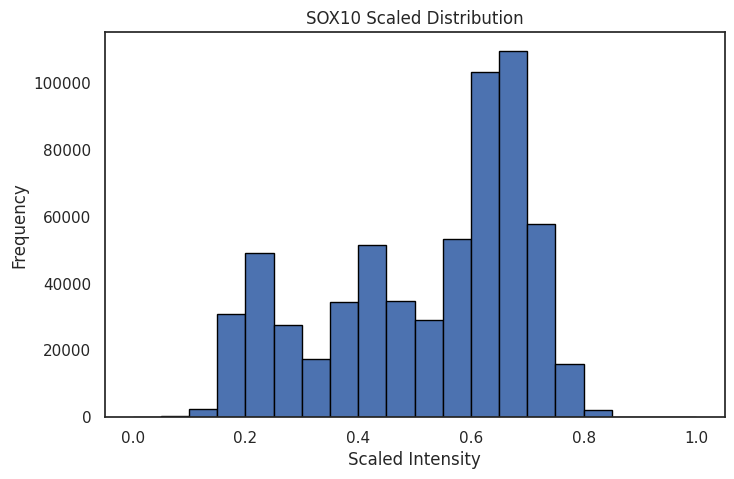

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(cell_adata[:,'SOX10'].X.flatten(), bins=20, range=(0, 1), edgecolor='black')
plt.title("SOX10 Scaled Distribution")
plt.xlabel("Scaled Intensity")
plt.ylabel("Frequency")
plt.show()

# Move output files back to bucket

In [ ]:
!gsutil cp /typed_intensity_anndata/scimap_auto_gating.csv gs://single_sample_features/cell_type_assignments/scimap_auto_gating.csv

Copying file:///typed_intensity_anndata/scimap_auto_gating.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][776.8 MiB/776.8 MiB]                                                
Operation completed over 1 objects/776.8 MiB.                                    


In [ ]:
!gsutil cp /typed_intensity_anndata/scimap_auto_gating_region_573.csv gs://single_sample_features/cell_type_assignments/region_subset_files/scimap_auto_gating_region_573.csv

Copying file:///typed_intensity_anndata/scimap_auto_gating_region_573.csv [Content-Type=text/csv]...
/ [1 files][  2.8 MiB/  2.8 MiB]                                                
Operation completed over 1 objects/2.8 MiB.                                      
